In [48]:
import mesa #for MESA
import seaborn as sns #data visualization
import numpy as np
import pandas as pd


Create an agent by creating a new class that extends `mesa.Agent`

In [49]:
class MoneyAgent(mesa.Agent):
  """A money agent with a fixed amount of initial wealth."""
  def __init__(self, unique_id, model, num_other_agents):
    #need to be initialized by a unique id and the model (defined later) where it will belong to
    #pass the params to the parent class
    super().__init__(unique_id, model)
    #define our extra variables for our agents as the above just creates an "empty" object
    self.wealth=1
    #set the number of all agents to be represented because it will be needed for padding the id with leading zeroes when printed
    self.padding = len(str(num_other_agents))

  #every agent is expected to have a step() function for the scheduler to call
  def step(self):
    
    #let's add one unit of money to a random other agent
    if self.wealth>0: #we should have at least one unit sia
      other_agent = self.random.choice(self.model.schedule.agents)
      if other_agent is not None: #there is someone else I can give money to
        other_agent.wealth += 1
        self.wealth -= 1
    
    # print(f"agent #{self.unique_id:0{self.padding}d} has a wealth of {self.wealth}")


Create the model. The model can be visualized as a grid containing all the agents. The model creates, holds and manages all the agents on the grid. The model evolves in discrete time steps.


In [50]:
class MoneyModel(mesa.Model):
  """A money model with some agents"""
  def __init__(self, N): #the number of agents is specified by N
    super().__init__()
    #set the number of agents
    self.num_agents = N
    """ 
      Add the scheduler. The scheduler controls the order in which agents are activated, 
      causing the agent to take their defined action. 
      The scheduler is also responsible for advancing the model by one step. Hence,
    """
    # Create scheduler and assign it to the model
    self.schedule = mesa.time.RandomActivation(self)
    #create agents
    for i in range(0,self.num_agents):
      a = MoneyAgent(i, self, num_other_agents=self.num_agents)
      #add agent to scheduler
      self.schedule.add(a)

  def step(self):
    """ Advance the model by one step """
    self.schedule.step() #this will call the step() function of each agent
 


Running the model

In [51]:
#instantiate the model
my_money_model = MoneyModel(12)
#run the model a couple of times
num_steps=10
for i in range(0,num_steps):
  my_money_model.step()
  # print("======================")

Let's get some information out of the model

[2, 1, 2, 0, 1, 2, 0, 3, 0, 0, 1, 0]


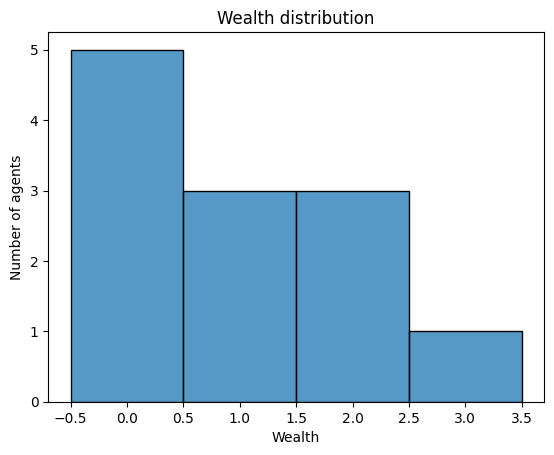

In [58]:
#list of agent wealths
agent_wealth = [a.wealth for a in my_money_model.schedule.agents]
print(agent_wealth)
#create plot using seaborn
g = sns.histplot(agent_wealth, discrete=True)
g.set(title="Wealth distribution",
      xlabel="Wealth",
      ylabel="Number of agents"); #semicolon avoids printing out the object info